Import libraries.

In [5]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import json
from tqdm import tqdm_notebook
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error

The following code will help to throw away all HTML tags from an article content.

In [8]:
from HTMLParser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [9]:
PATH_TO_DATA = ''

Assume you have all data downloaded from competition's [page](https://www.kaggle.com/c/how-good-is-your-medium-article/data) in the PATH_TO_DATA folder and `.gz` files are ungzipped.

In [10]:
!ls -l $PATH_TO_DATA

итого 3167144
-rw-rw-r-- 1 danil danil      20033 мар 26 17:14 notebook.ipynb
-rw-rw-r-- 1 danil danil 1156020029 мар 26 17:07 test.json
-rw-rw-r-- 1 danil danil 2086185062 мар 26 17:02 train.json
-rw-rw-r-- 1 danil danil     912544 мар 26 17:01 train_log1p_recommends.csv


Supplementary function to read a JSON line without crashing on escape characters. 

In [11]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

This function takes a JSON and forms a txt file leaving only article content. When you resort to feature engineering and extract various features from articles, a good idea is to modify this function.

In [69]:
def preprocess(path_to_inp_json_file):
    output_list = []
    timestamp = []
    spider = []
    url = []
    domain= []
    published = []
    title = []
    out_data=pd.DataFrame()
    with open(path_to_inp_json_file) as inp_file:
        for line in tqdm_notebook(inp_file):
            json_data = read_json_line(line)
            content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            output_list.append(content_no_html_tags)
            timestamp.append(json_data['_timestamp'])
            spider.append(json_data['_spider'])
            url.append(json_data['url'])
            domain.append(json_data['domain'])
            published.append(json_data['published'])
            title.append(json_data['title'])
    out_data['_timestamp']=timestamp
    out_data['_spider']=spider
    out_data['url']=url
    out_data['domain']=domain
    out_data['published']=published
    out_data['title']=title
    return output_list,out_data

In [70]:
%%time
train_raw_content, other_train_data = preprocess(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 
                                                                  'train.json'),)

Widget Javascript not detected.  It may not be installed or enabled properly.


ValueError: too many values to unpack

In [16]:
%%time
test_raw_content, other_test_data = preprocess(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 
                                                                  'test.json'),)

Widget Javascript not detected.  It may not be installed or enabled properly.



CPU times: user 2min 29s, sys: 2.47 s, total: 2min 31s
Wall time: 2min 29s


We'll use a linear model (`Ridge`) with a very simple feature extractor – `CountVectorizer`, meaning that we resort to the Bag-of-Words approach. For now, we are leaving only 50k features. 

**pymorphy**

In [43]:
from pymorphy import get_morph
morph = get_morph('/home/danil/GitHub/mlcourse_open/jupyter_russian/project Medium/dict/en')

#слова должны быть в юникоде и ЗАГЛАВНЫМИ
norm_text=morph.normalize(train_raw_content[1].upper())
#https://pythonhosted.org/pymorphy/intro.html#id2

In [48]:
cv = CountVectorizer(max_features=50000)

In [49]:
%%time
X_train = cv.fit_transform(train_raw_content)

CPU times: user 1min 37s, sys: 1.03 s, total: 1min 38s
Wall time: 1min 38s


In [50]:
%%time
X_test = cv.transform(test_raw_content)

CPU times: user 57.6 s, sys: 124 ms, total: 57.7 s
Wall time: 57.6 s


In [51]:
X_train.shape, X_test.shape

((62313, 50000), (34645, 50000))

Read targets from file.

In [52]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_log1p_recommends.csv'), 
                           index_col='id')

In [53]:
train_target.shape

(62313, 1)

In [54]:
y_train = train_target['log_recommends'].values

Make a 30%-holdout set. 

In [55]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part = X_train[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid =  X_train[train_part_size:, :]
y_valid = y_train[train_part_size:]

Now we are ready to fit a linear model.

In [56]:
from sklearn.linear_model import Ridge

In [57]:
ridge = Ridge(random_state=17)

In [58]:
%%time
ridge.fit(X_train_part, y_train_part);

CPU times: user 2min 51s, sys: 20 ms, total: 2min 51s
Wall time: 2min 51s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [59]:
ridge_pred = ridge.predict(X_valid)

Let's plot predictions and targets for the holdout set. Recall that these are #recommendations (= #claps) of Medium articles with the `np.log1p` transformation.

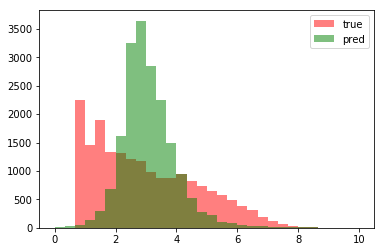

In [60]:
plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();

As we can see, the prediction is far from perfect, and we get MAE $\approx$ 1.3 that corresponds to $\approx$ 2.7 error in #recommendations.

In [61]:
valid_mae = mean_absolute_error(y_valid, ridge_pred)
valid_mae, np.expm1(valid_mae)

(1.3060482880183237, 2.6915568809205532)

Finally, train the model on the full accessible training set, make predictions for the test set and form a submission file. 

In [62]:
%%time
ridge.fit(X_train, y_train);

CPU times: user 4min 17s, sys: 364 ms, total: 4min 17s
Wall time: 4min 18s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [63]:
%%time
ridge_test_pred = ridge.predict(X_test)

CPU times: user 88 ms, sys: 0 ns, total: 88 ms
Wall time: 88.1 ms


In [64]:
def write_submission_file(prediction, filename,
    path_to_sample=os.path.join(PATH_TO_DATA, 'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [66]:
write_submission_file(prediction=ridge_test_pred, 
                      filename='first_ridge.csv')

With this, you'll get 1.91185 on [public leaderboard](https://www.kaggle.com/c/how-good-is-your-medium-article/leaderboard). This is much higher than our validation MAE. This indicates that the target distribution in test set somewhat differs from that of the training set (recent Medium articles are more popular). This shouldn't confuse us as long as we see a correlation between local improvements and improvements on the leaderboard. 

Some ideas for improvement:
- Engineer good features, this is the key to success. Some simple features will be based on publication time, authors, content length and so on
- You may not ignore HTML and extract some features from there
- You'd better experiment with your validation scheme. You should see a correlation between your local improvements and LB score
- Try TF-IDF, ngrams, Word2Vec and GloVe embeddings
- Try various NLP techniques like stemming and lemmatization
- Tune hyperparameters. In our example, we've left only 50k features and used `C`=1 as a regularization parameter, this can be changed 
- SGD and Vowpal Wabbit will learn much faster
- In our course, we don't cover neural nets. But it's not obliged to use GRUs or LSTMs in this competition. 